<a href="https://colab.research.google.com/github/aizzaauliya/Tugas-Besar-Pembelajaran-Mesin-2018-143_2017-183/blob/main/skin_cancer_image__analysis_using_cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1 : importing Essential Libraries**

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [4]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

**Step 2 : Making Dictionary of images and labels**

In [5]:
base_skin_dir = os.path.join('..', 'input')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

**Step 3 : Reading & Processing data**

Pada langkah ini kita telah membaca csv dengan menggabungkan path folder gambar yang merupakan folder dasar tempat semua gambar ditempatkan bernama base_skin_dir. Setelah itu kami membuat beberapa kolom baru yang mudah dipahami untuk referensi nanti seperti kami telah membuat kolom path yang berisi image_id, cell_type yang berisi nama pendek dari jenis lesi dan terakhir kami telah membuat kolom kategoris cell_type_idx yang telah kami kategorikan jenis lesi menjadi kode dari 0 hingga 6

In [9]:
skin_df = pd.read_csv('HAM10000_metadata.csv')

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [10]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,None,Benign keratosis-like lesions,2


**Step 4 : Data Cleaning**

Pada langkah ini kami memeriksa nilai yang hilang dan tipe data dari setiap bidang

In [11]:
skin_df.isnull().sum()

lesion_id            0
image_id             0
dx                   0
dx_type              0
age                 57
sex                  0
localization         0
path             10015
cell_type            0
cell_type_idx        0
dtype: int64

Seperti terbukti dari atas bahwa hanya usia yang memiliki nilai nol yaitu 57 jadi kami akan mengisi nilai nol dengan rata-ratanya.

In [12]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

Sekarang, mari kita periksa keberadaan nilai nol lagi

In [13]:
skin_df.isnull().sum()

lesion_id            0
image_id             0
dx                   0
dx_type              0
age                  0
sex                  0
localization         0
path             10015
cell_type            0
cell_type_idx        0
dtype: int64

In [14]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


**Step 5 : EDA**

Dalam hal ini kita akan mengeksplorasi fitur yang berbeda dari dataset, distribusi dan jumlah sebenarnya


Plot untuk melihat distribusi 7 kelas tipe sel yang berbeda

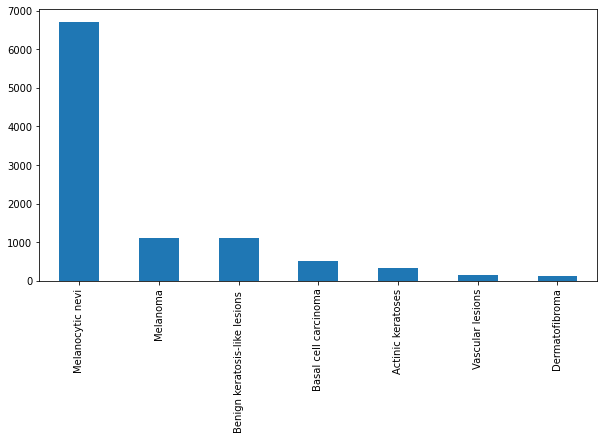

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

Tampaknya dari plot di atas bahwa dalam tipe sel dataset ini Melanecytic nevi memiliki jumlah instance yang sangat besar dibandingkan dengan tipe sel lainnya

Plotting bidang Technical Validation (ground truth) yang bertipe dx_type untuk melihat distribusi 4 kategorinya yang tercantum di bawah ini :
1. Histopatologi (Histo): Diagnosis histopatologi dari lesi yang dipotong telah dilakukan oleh ahli dermatopatologi khusus.
2. Confocal: Reflectance confocal microscopy adalah teknik pencitraan in-vivo dengan resolusi mendekati tingkat sel, dan beberapa wajah jinak dengan asumsi dunia abu-abu dari semua gambar set pelatihan di ruang warna Lab sebelum dan sesudah perubahan histogram manual .
3. Tindak lanjut: Jika nevi yang dipantau dengan dermatoskopi digital tidak menunjukkan perubahan apa pun selama 3 kunjungan tindak lanjut atau 1,5 tahun, ahli biologi menerima ini sebagai bukti jinak biologis. Hanya nevi, tetapi tidak ada diagnosis jinak lainnya yang diberi label dengan jenis kebenaran dasar ini karena dokter kulit biasanya tidak memantau dermatofibroma, keratosis seboroik, atau lesi vaskular.
4. Konsensus: Untuk kasus jinak yang khas tanpa histopatologi atau ahli biologi tindak lanjut memberikan peringkat ahli-konsensus penulis PT dan HK. Mereka menerapkan label konsensus hanya jika kedua penulis secara independen memberikan diagnosis jinak yang sama. Lesi dengan jenis groundtruth ini biasanya difoto untuk alasan pendidikan dan tidak memerlukan tindak lanjut lebih lanjut atau biopsi untuk konfirmasi.

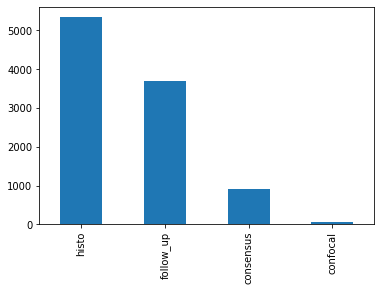

In [16]:
skin_df['dx_type'].value_counts().plot(kind='bar')

Merencanakan sebaran bidang pelokalan

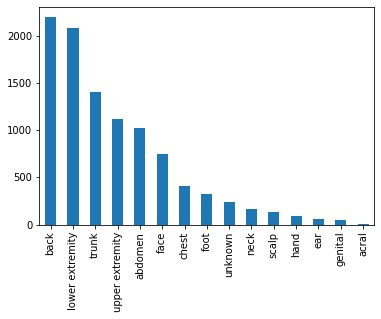

In [17]:
skin_df['localization'].value_counts().plot(kind='bar')

Tampaknya punggung, ekstremitas bawah, batang tubuh dan ekstremitas atas adalah daerah yang sangat rentan terkena kanker kulit

Sekarang, periksa distribusi Age

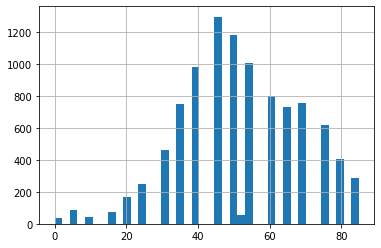

In [18]:
skin_df['age'].hist(bins=40)

Mari kita lihat distribusi pria dan wanita

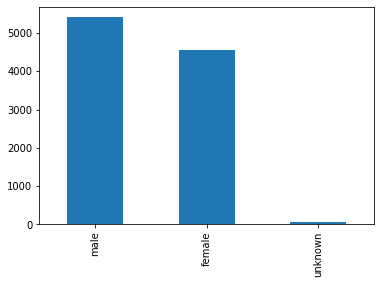

In [19]:
skin_df['sex'].value_counts().plot(kind='bar')

Sekarang mari kita visualisasikan distribusi jenis kanker kulit berdasarkan usia

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


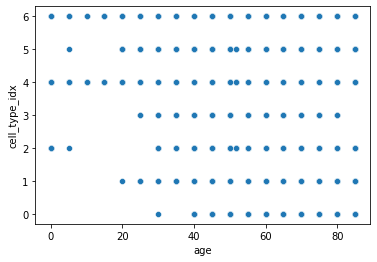

In [20]:
sns.scatterplot('age','cell_type_idx',data=skin_df)

Nampaknya kanker kulit tipe 0,1, 3 dan 5 yaitu Melanocytic Nevi, Dermatofibroma, Basal Cell Carcinoma dan Vascular Lesi tidak banyak terjadi pada usia dibawah 20 tahun.

Distribusi jenis kanker kulit berdasarkan jenis kelamin 

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


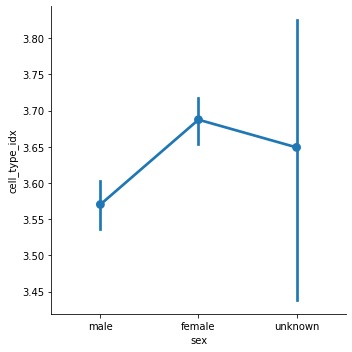

In [21]:
sns.factorplot('sex','cell_type_idx',data=skin_df)

**Step 6: Loading and resizing of images**

Pada langkah ini gambar akan dimuat ke dalam kolom bernama gambar dari jalur gambar dari folder gambar. Kami juga mengubah ukuran gambar karena dimensi asli gambar adalah 450 x 600 x3 yang tidak dapat ditangani oleh TensorFlow, oleh karena itu kami mengubah ukurannya menjadi 100 x 75. Sebagai langkah ini, ubah ukuran semua dimensi 10015 gambar menjadi 100x 75 jadi bersabarlah akan memakan waktu.



In [22]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

AttributeError: ignored

In [23]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,None,Benign keratosis-like lesions,2


**Seperti yang kita lihat, kolom gambar telah ditambahkan dalam kode format warnanya**

Bagian yang paling menarik selalu lebih baik untuk melihat contoh gambar Di bawah ini kami akan menampilkan gambar dari setiap jenis kanker

KeyError: ignored

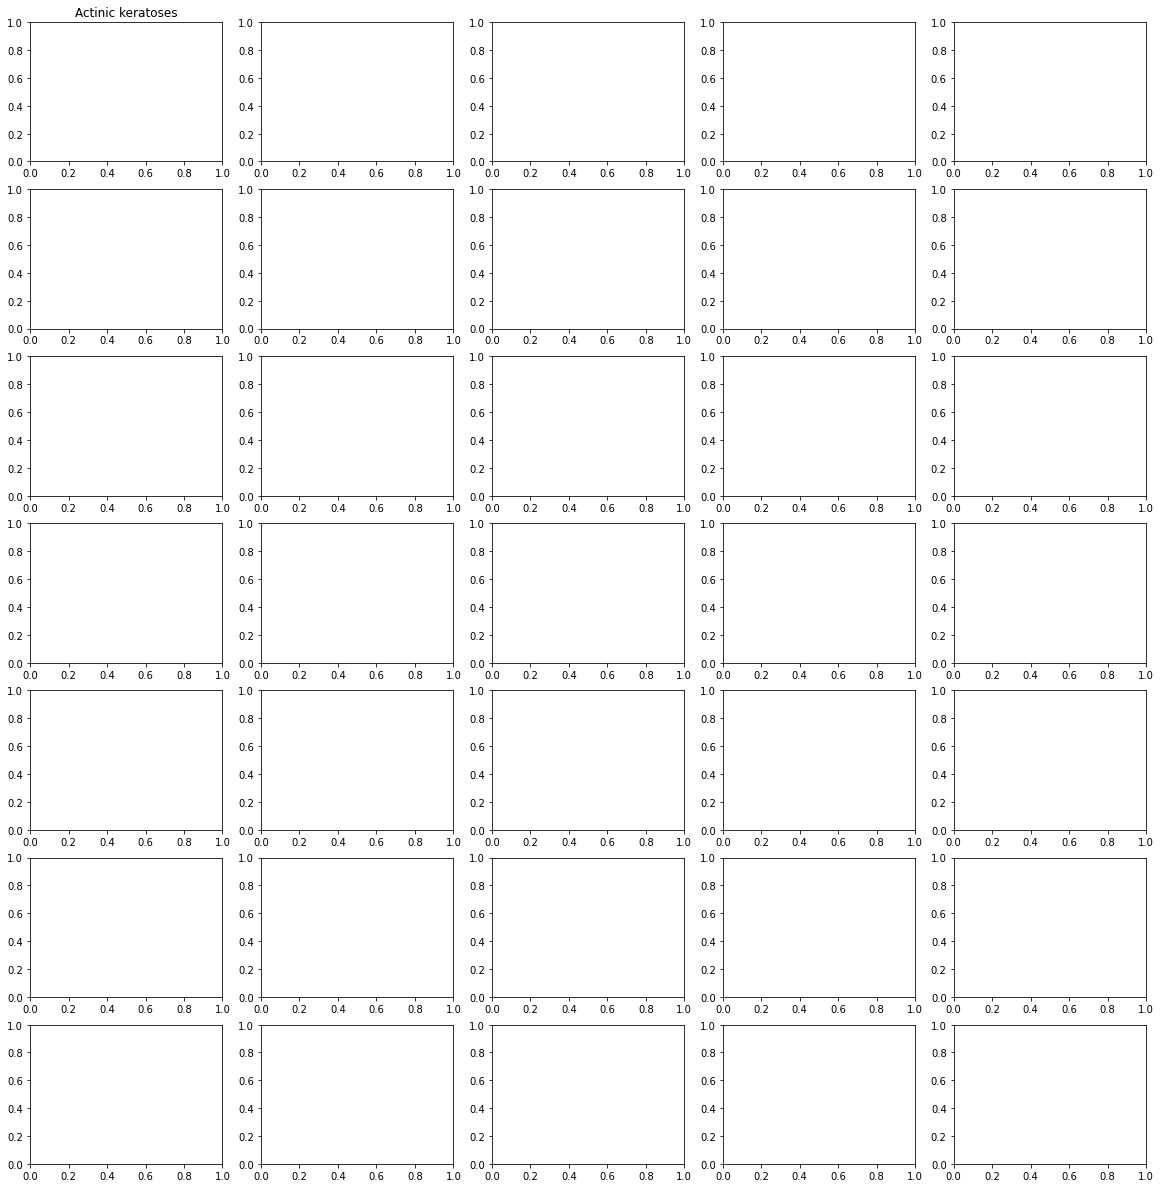

In [24]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)


In [ ]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

In [ ]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

**Step 7 : Train Test Split**

Pada langkah ini kami telah membagi dataset menjadi training dan testing set dengan rasio 80:20

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

**Step 8 : Normalization**

Saya memilih untuk menormalkan x_train, x_test dengan mengurangi nilai rata-ratanya dan kemudian membaginya dengan standar deviasinya.

In [ ]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

**Step 9 : Label Encoding**

Label adalah 7 kelas berbeda dari jenis kanker kulit dari 0 hingga 6. Kita perlu mengkodekan label ke satu vektor panas

In [ ]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

**Step 10 : Splitting training and validation split**

Saya memilih untuk membagi rangkaian kereta menjadi dua bagian: sebagian kecil (10%) menjadi rangkaian validasi yang modelnya dievaluasi dan sisanya (90%) digunakan untuk melatih model.

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [ ]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

**Step 11: Model Building**

**CNN**

Saya menggunakan Keras Sequential API, di mana Anda hanya perlu menambahkan satu lapisan pada satu waktu, mulai dari input.

Yang pertama adalah lapisan convolutional (Conv2D). Ini seperti seperangkat filter yang dapat dipelajari. Saya memilih untuk mengatur 32 filter untuk dua lapisan konv2D pertama dan 64 filter untuk dua yang terakhir. Setiap filter mengubah bagian dari gambar (didefinisikan oleh ukuran kernel) menggunakan filter kernel. Matriks filter kernel diterapkan pada seluruh gambar. Filter dapat dilihat sebagai transformasi gambar.

CNN dapat mengisolasi fitur yang berguna di mana saja dari gambar yang diubah ini (peta fitur).

Lapisan penting kedua di CNN adalah lapisan pooling (MaxPool2D). Lapisan ini hanya bertindak sebagai filter downsampling. Itu terlihat pada 2 piksel tetangga dan mengambil nilai maksimal. Ini digunakan untuk mengurangi biaya komputasi, dan sampai batas tertentu juga mengurangi overfitting. Kita harus memilih ukuran pooling (yaitu ukuran area yang dikumpulkan setiap kali) semakin besar dimensi pooling, semakin penting downsampling.

Menggabungkan lapisan convolutional dan pooling, CNN mampu menggabungkan fitur lokal dan mempelajari lebih banyak fitur global gambar.

Dropout adalah metode regularisasi, di mana proporsi node dalam lapisan diabaikan secara acak (menetapkan bobotnya ke nol) untuk setiap sampel pelatihan. Ini menjatuhkan secara acak proposisi jaringan dan memaksa jaringan untuk mempelajari fitur secara terdistribusi. Teknik ini juga meningkatkan generalisasi dan mengurangi overfitting.

'relu' adalah penyearah (fungsi aktivasi max(0,x). Fungsi aktivasi penyearah digunakan untuk menambahkan non linieritas ke jaringan.

Lapisan Flatten digunakan untuk mengubah peta fitur akhir menjadi satu vektor 1D tunggal. Langkah perataan ini diperlukan agar Anda dapat menggunakan lapisan yang terhubung penuh setelah beberapa lapisan convolutional/maxpool. Ini menggabungkan semua fitur lokal yang ditemukan dari lapisan konvolusi sebelumnya.

Pada akhirnya saya menggunakan fitur dalam dua lapisan yang terhubung penuh (Dense) yang hanya pengklasifikasi jaringan saraf tiruan (ANN). Di lapisan terakhir(Dense(10,activation="softmax")) distribusi keluaran bersih dari probabilitas setiap kelas.

In [ ]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

**Step 14: Model Evaluation**

Pada langkah ini kami akan memeriksa akurasi pengujian dan akurasi validasi model kami, matriks kebingungan plot dan juga memeriksa jumlah gambar yang salah klasifikasi dari setiap jenis

In [ ]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 


Sekarang, mari kita kategori mana yang memiliki banyak prediksi yang salah

In [ ]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')